In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Configurações para visualização
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)

# Carregando o dataset com os parâmetros corretos
df = pd.read_csv('../datasets/AirQualityUCI.csv', 
                 sep=';',  # Separador de colunas
                 decimal=',',  # Separador decimal
                 encoding='utf-8')  # Encoding do arquivo

# Substituindo -200 por NaN
df = df.replace(-200, pd.NA)

# Removendo colunas vazias ou desnecessárias
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, errors='ignore')

# Preparando X e y
y = df['CO(GT)']
X = df.drop('CO(GT)', axis=1)


In [22]:
# Verificando informações gerais
print("\n--- Informações do Dataset ---")
print(f"Formato do dataset: {df.shape}")
print("\nPrimeiras 5 linhas:")
print(df.head())

print("\nInformações do dataset:")
df.info()

print("\nEstatísticas descritivas:")
print(df.describe())


--- Informações do Dataset ---
Formato do dataset: (9471, 17)

Primeiras 5 linhas:
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 

Análise Exploratória

In [23]:
# Verificando valores ausentes
print("\nVerificando valores ausentes:")
missing_values = df.isnull().sum()
print(missing_values)

# Substituindo -200 por NaN (valores faltantes no dataset são marcados como -200)
for col in df.columns:
    if df[col].dtype != object:  # Aplicar apenas em colunas numéricas
        df[col] = df[col].replace(-200, np.nan)

# Verificando valores ausentes após substituição
print("\nValores ausentes após substituição de -200 por NaN:")
missing_values_after = df.isnull().sum()
print(missing_values_after)
print(f"Porcentagem de valores ausentes: {(missing_values_after.sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

# Tratando colunas de Data e Hora
# Combinando Data e Hora em um único timestamp
df['Date'] = df['Date'].str.replace('/', '-')
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H.%M.%S')
df = df.drop(['Date', 'Time'], axis=1)


Verificando valores ausentes:
Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

Valores ausentes após substituição de -200 por NaN:
Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64
Porcentagem de valores ausentes: 23.20%


In [24]:
# Removendo qualquer coluna não numérica restante (exceto Timestamp)
non_numeric_cols = [col for col in df.columns if col != 'Timestamp' and df[col].dtype == object]
if non_numeric_cols:
    print(f"\nRemovendo colunas não numéricas: {non_numeric_cols}")
    df = df.drop(non_numeric_cols, axis=1)


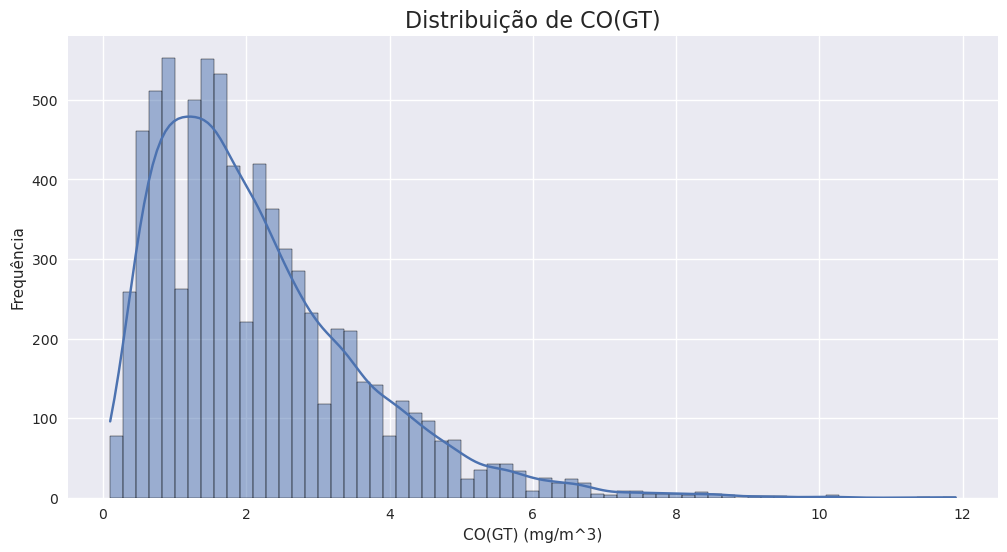

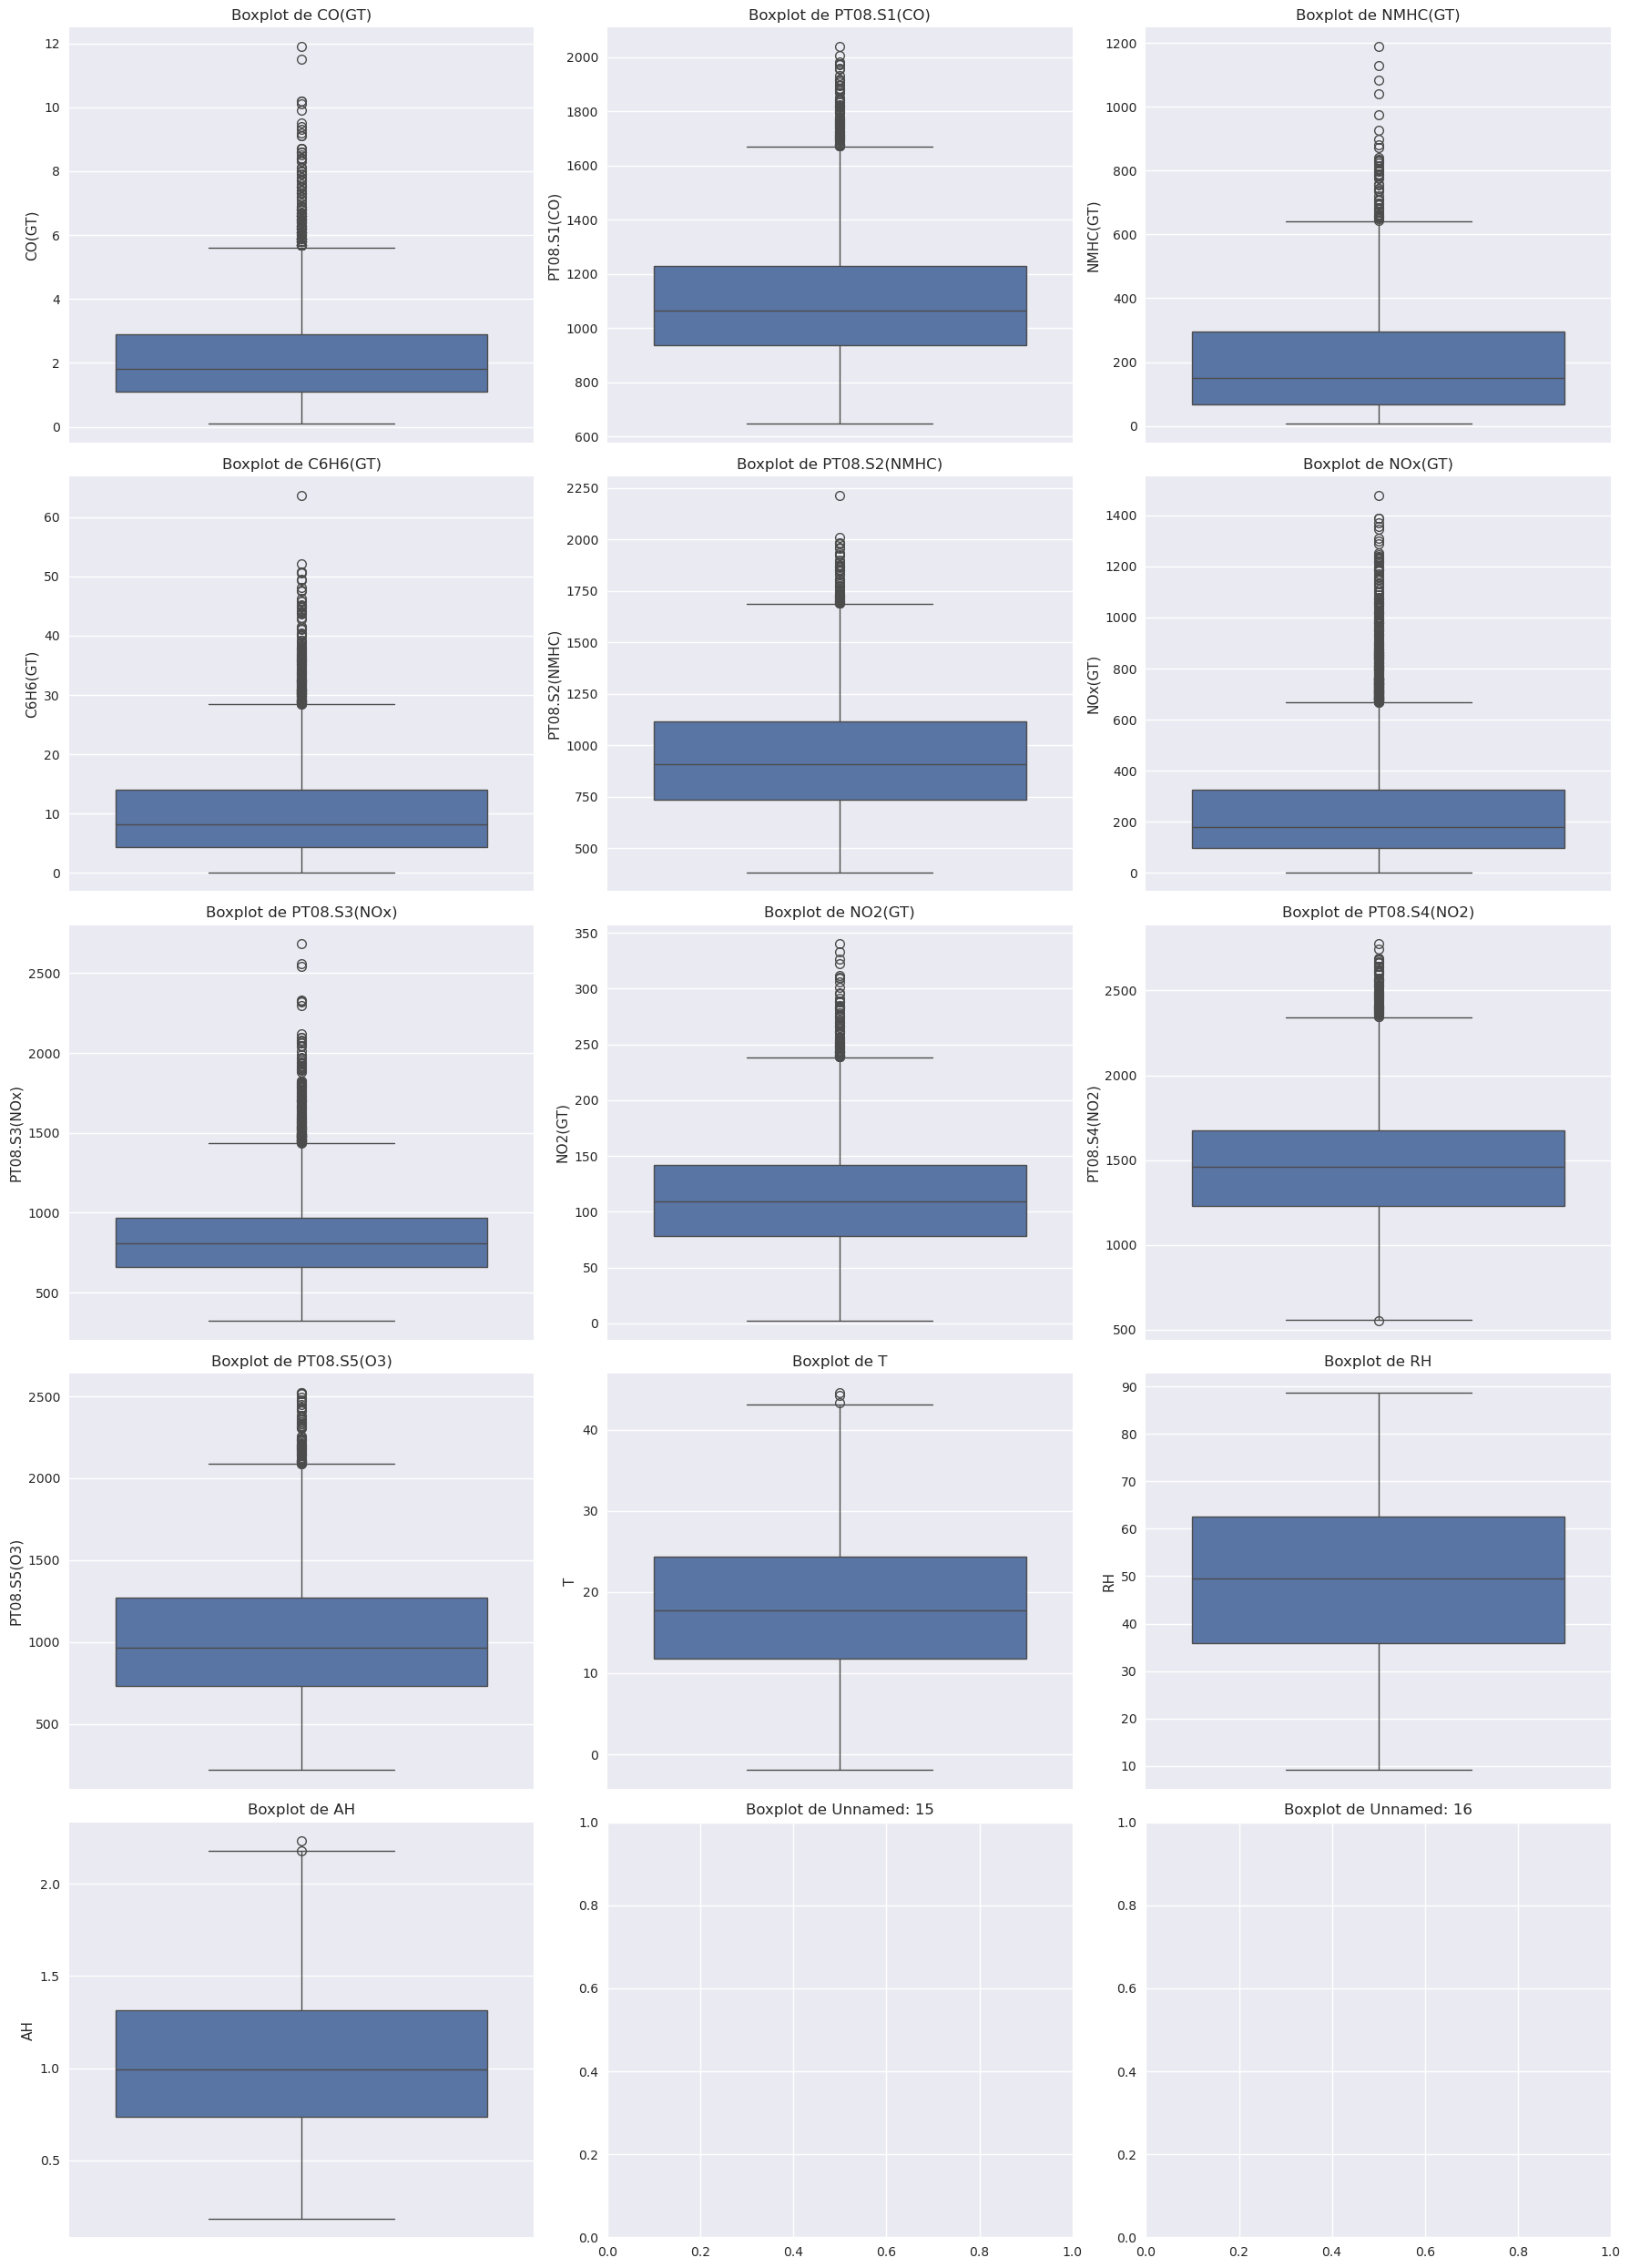

In [25]:
# Distribuição da variável alvo CO(GT)
plt.figure(figsize=(12, 6))
sns.histplot(df['CO(GT)'].dropna(), kde=True)
plt.title('Distribuição de CO(GT)', size=16)
plt.xlabel('CO(GT) (mg/m^3)')
plt.ylabel('Frequência')
plt.show()

# Boxplots das variáveis principais
numerical_cols = [col for col in df.columns if col != 'Timestamp' and df[col].dtype != object]
num_cols = len(numerical_cols)
rows = (num_cols + 2) // 3  # Arredondando para cima

plt.figure(figsize=(18, 5 * rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(rows, 3, i+1)
    sns.boxplot(y=df[col].dropna())
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()
plt.show()


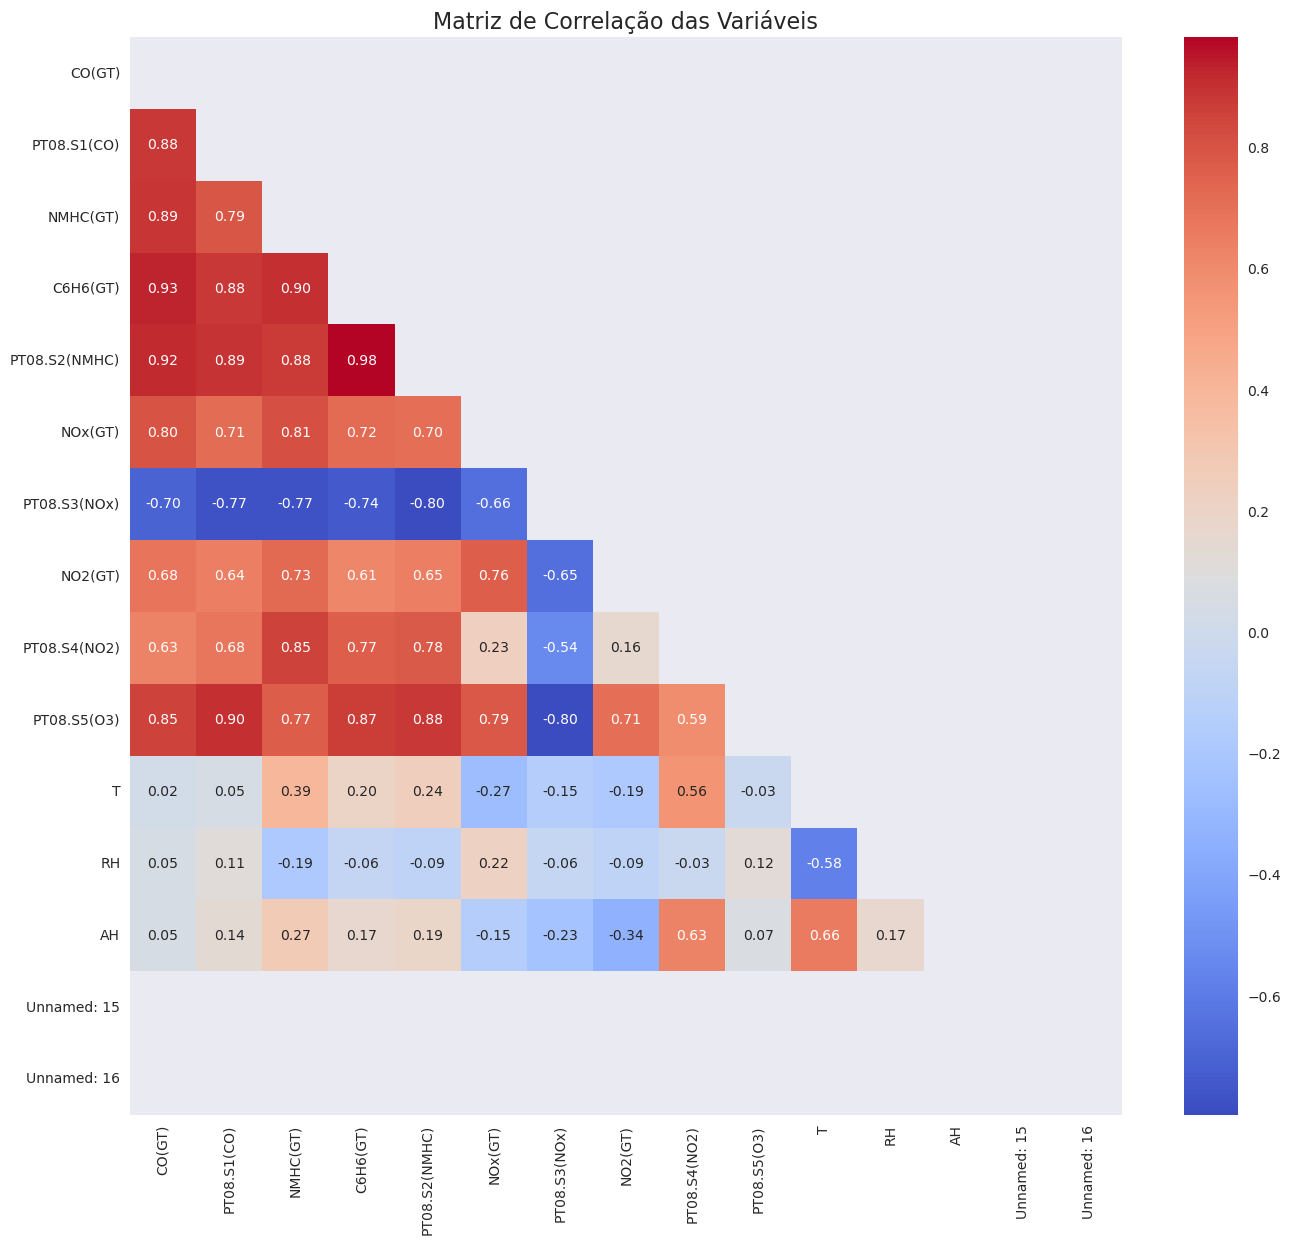


Correlações com CO(GT):
CO(GT)           1.000000
C6H6(GT)         0.931078
PT08.S2(NMHC)    0.915514
NMHC(GT)         0.889734
PT08.S1(CO)      0.879288
PT08.S5(O3)      0.854182
NOx(GT)          0.795028
NO2(GT)          0.683343
PT08.S4(NO2)     0.630703
RH               0.048890
AH               0.048556
T                0.022109
PT08.S3(NOx)    -0.703446
Unnamed: 15           NaN
Unnamed: 16           NaN
Name: CO(GT), dtype: float64


In [26]:
# Matriz de correlação
plt.figure(figsize=(16, 14))
correlation_matrix = df.drop('Timestamp', axis=1).corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Matriz de Correlação das Variáveis', size=16)
plt.show()

# Correlação com a variável alvo
print("\nCorrelações com CO(GT):")
correlations = correlation_matrix['CO(GT)'].sort_values(ascending=False)
print(correlations)


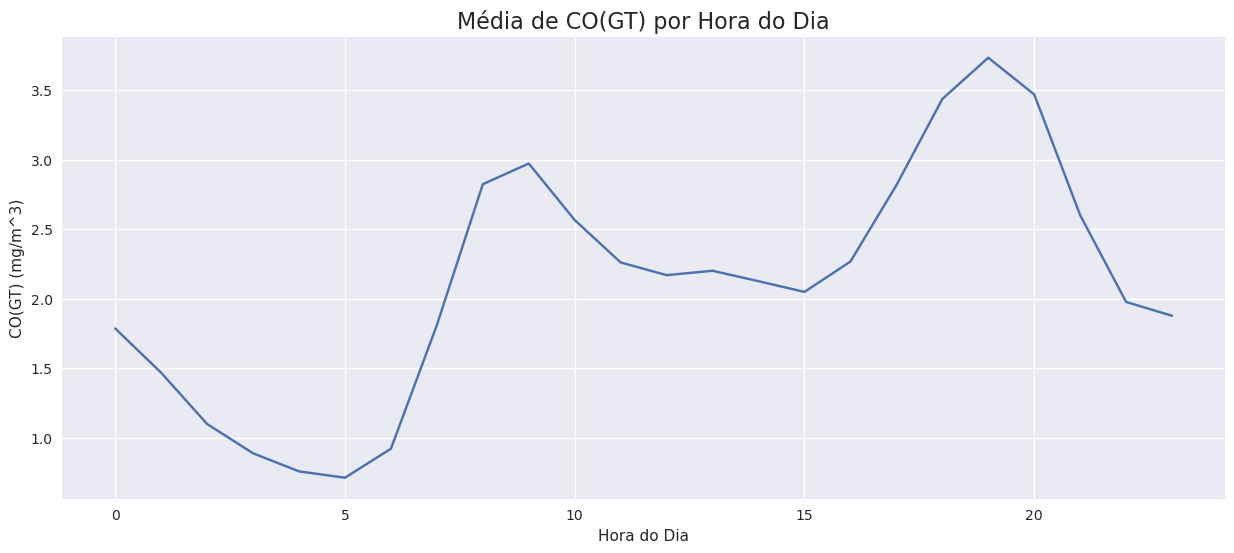

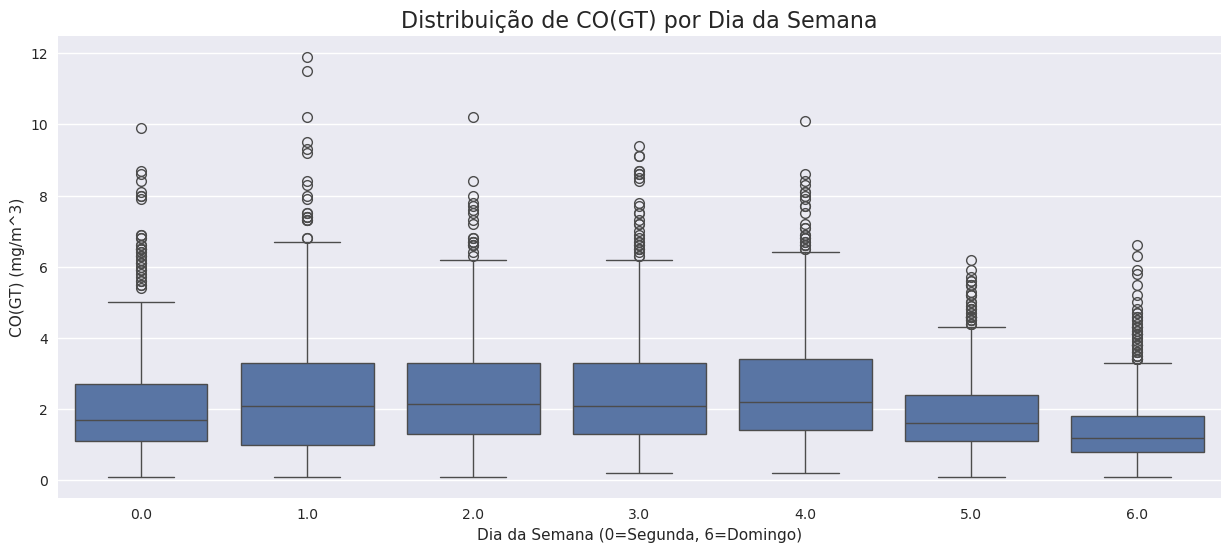

In [27]:
# Análise temporal
# Agrupando por hora do dia para ver padrões diários
df['Hour'] = df['Timestamp'].dt.hour
plt.figure(figsize=(15, 6))
sns.lineplot(x='Hour', y='CO(GT)', data=df, estimator='mean', errorbar=None)
plt.title('Média de CO(GT) por Hora do Dia', size=16)
plt.xlabel('Hora do Dia')
plt.ylabel('CO(GT) (mg/m^3)')
plt.grid(True)
plt.show()

# Agrupando por dia da semana
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
plt.figure(figsize=(15, 6))
sns.boxplot(x='DayOfWeek', y='CO(GT)', data=df)
plt.title('Distribuição de CO(GT) por Dia da Semana', size=16)
plt.xlabel('Dia da Semana (0=Segunda, 6=Domingo)')
plt.ylabel('CO(GT) (mg/m^3)')
plt.show()

Pré-processamento

In [28]:
print("\n--- Pré-processamento de Dados ---")

# Separando variáveis temporais
df_time_features = pd.DataFrame({
    'Hour': df['Hour'],
    'DayOfWeek': df['DayOfWeek'],
    'Month': df['Timestamp'].dt.month,
    'Day': df['Timestamp'].dt.day
})

# Removendo timestamp e colunas temporais extraídas
df_clean = df.drop(['Timestamp', 'Hour', 'DayOfWeek'], axis=1)

# SUBSTITUA ESTA PARTE:
# ----------------------------------------
# Tratamento de valores ausentes
print("\nTratando valores ausentes...")
# Para dados de qualidade do ar, geralmente é melhor usar métodos de imputação que consideram a série temporal
# Utilizaremos método de forward fill seguido por backward fill para valores ausentes
df_clean = df_clean.ffill().bfill()

# Verificando se ainda existem valores ausentes
missing_after_imputation = df_clean.isnull().sum()
print("Valores ausentes após imputação:")
print(missing_after_imputation)

# Se ainda houver valores ausentes, podemos usar a média das colunas
if missing_after_imputation.sum() > 0:
    print("Preenchendo valores ausentes restantes com a média...")
    df_clean = df_clean.fillna(df_clean.mean())


--- Pré-processamento de Dados ---

Tratando valores ausentes...
Valores ausentes após imputação:
CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)            0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64
Preenchendo valores ausentes restantes com a média...


In [29]:
# Tratamento de valores ausentes
print("\nTratando valores ausentes...")
# Primeiro tenta com forward fill e backward fill
df_clean = df_clean.ffill().bfill()

# Verifica se ainda existem valores ausentes
missing_after_imputation = df_clean.isnull().sum()
print("Valores ausentes após primeira imputação:")
print(missing_after_imputation)

# Preenche todos os valores ausentes restantes com a média das colunas
if missing_after_imputation.sum() > 0:
    print("Preenchendo valores ausentes restantes com a média...")
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

# Verificação final para garantir que não há mais NaN
final_check = df_clean.isnull().sum().sum()
if final_check > 0:
    print(f"ATENÇÃO: Ainda existem {final_check} valores ausentes!")
    # Última tentativa: remover linhas com NaN
    print("Removendo linhas com valores ausentes restantes...")
    df_clean = df_clean.dropna()
    print(f"Número de linhas após remoção: {len(df_clean)}")
else:
    print("Não há mais valores ausentes nos dados.")



Tratando valores ausentes...
Valores ausentes após primeira imputação:
CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)            0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64
Preenchendo valores ausentes restantes com a média...
ATENÇÃO: Ainda existem 18942 valores ausentes!
Removendo linhas com valores ausentes restantes...
Número de linhas após remoção: 0


In [32]:
# 1. Primeiro, vamos verificar onde estão os NaN
print("Verificando valores NaN em cada coluna:")
for coluna in X.columns:
    nan_count = X[coluna].isnull().sum()
    if nan_count > 0:
        print(f"Coluna {coluna}: {nan_count} valores NaN")

# 2. Preenchimento dos valores NaN
print("\nPreenchendo valores NaN...")
X = X.fillna(X.mean())

# 3. Verificação final
nan_restantes = X.isnull().sum().sum()
print(f"\nNúmero de NaN restantes: {nan_restantes}")

# 4. Se ainda houver NaN (pode acontecer se uma coluna for totalmente NaN)
if nan_restantes > 0:
    print("Ainda existem NaN. Removendo linhas com NaN restantes...")
    X = X.dropna()
    print(f"Shape após remoção de NaN: {X.shape}")

Verificando valores NaN em cada coluna:
Coluna Date: 114 valores NaN
Coluna Time: 114 valores NaN
Coluna PT08.S1(CO): 480 valores NaN
Coluna NMHC(GT): 8557 valores NaN
Coluna C6H6(GT): 480 valores NaN
Coluna PT08.S2(NMHC): 480 valores NaN
Coluna NOx(GT): 1753 valores NaN
Coluna PT08.S3(NOx): 480 valores NaN
Coluna NO2(GT): 1756 valores NaN
Coluna PT08.S4(NO2): 480 valores NaN
Coluna PT08.S5(O3): 480 valores NaN
Coluna T: 480 valores NaN
Coluna RH: 480 valores NaN
Coluna AH: 480 valores NaN

Preenchendo valores NaN...


TypeError: can only concatenate str (not "int") to str

In [33]:

# Concatenando com as features temporais
df_clean = pd.concat([df_clean, df_time_features], axis=1)

# Definindo variável alvo e features
y = df_clean['CO(GT)']
X = df_clean.drop('CO(GT)', axis=1)

# ADICIONE ESTA VERIFICAÇÃO ANTES DA PADRONIZAÇÃO:
# Verificação final antes da padronização
print("Verificando se ainda há valores ausentes antes da padronização:")
print(f"Valores NaN em X: {X.isnull().sum().sum()}")
print(f"Valores NaN em y: {y.isnull().sum()}")
# Em vez de usar assert, tratar os valores NaN
if X.isnull().sum().sum() > 0:
    print(f"Detectados {X.isnull().sum().sum()} valores NaN em X. Preenchendo com a média...")
    # Preencher NaN com a média de cada coluna
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    print("Valores NaN preenchidos com sucesso.")

# Padronização das features
print("Padronizando as features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Verificando se ainda há valores ausentes antes da padronização:
Valores NaN em X: 133050
Valores NaN em y: 9471
Detectados 133050 valores NaN em X. Preenchendo com a média...
Valores NaN preenchidos com sucesso.
Padronizando as features...
